## Семинар 10: "Генерация текстов"

ФИО: Сульженко Родион Вадимович

In [1]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output
import tqdm
import progressbar
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [2]:
lines = [x.split('\t')[1].strip() for x in open('author-quote.txt').readlines()]

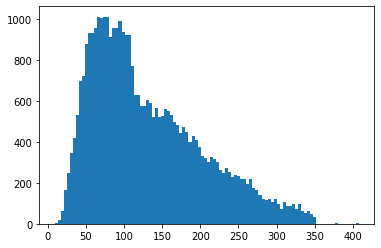

In [3]:
plt.hist(list(map(len, lines)), bins=100);

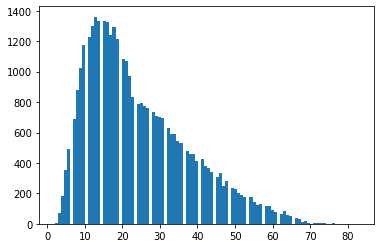

In [4]:
plt.hist(list(map(lambda x: len(x.split()), lines)), bins=100);

In [5]:
line = lines[0]

In [6]:
line

'If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.'

In [7]:
lines = list(filter(lambda x: len(x.split()) <= 50, lines))

In [8]:
np.random.seed(777)
torch.random.manual_seed(777)

In [9]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(sorted(all_characters))+['<eos>', '<go>']
        self.char_to_id = {x[1]:x[0] for x in enumerate(all_characters)}
        self.id_to_char = {x[0]:x[1] for x in enumerate(all_characters)}
        self.size = len(all_characters)

    def encode(self, line):
        return [self.char_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ''.join([self.id_to_char[x] for x in tokens])

In [10]:
vocab = Vocabulary(lines)

In [11]:
assert vocab.decode(vocab.encode(lines[0])) == lines[0]

In [12]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens)
        _output = np.array(tokens+[self.eos])
        return _input, _output

In [13]:
def compose_batch(batch):
    order = np.argsort([-len(x[0]) for x in batch])
    lengths = np.array([len(x[0]) for x in batch])
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [14]:
dataset = Quotes(lines, vocab)

In [15]:
dataloader = DataLoader(dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)

### Часть 2: определение модели

In [16]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.GRU(embedding_size, hidden_size, layers, batch_first=False)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(embedding, lengths)
        output, _ = self.generator(embedding)
        output = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output[0])
        return classes

    def generate(self, vocab, max_len=100):
        h = Variable(torch.zeros(self.layers, 1, self.hidden_size))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = Variable(token, volatile=True)
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [17]:
oracle = Oracle(vocab.size, embedding_size=32, hidden_size=64, layers=2)

### Часть 3: обучение модели

In [18]:
optimizer = torch.optim.RMSprop(oracle.parameters(), lr=0.001, weight_decay=1e-5)

In [19]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [20]:
losses = []

In [21]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

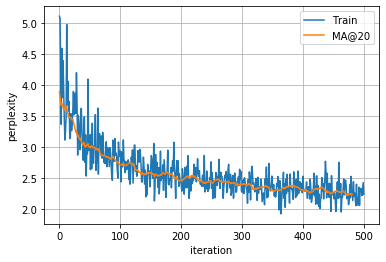

100%|██████████| 536/536 [15:29<00:00,  1.73s/it]


In [22]:
for epoch in range(1):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(dataloader, total=len(dataloader))):
        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        losses.append(np.exp(loss.item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

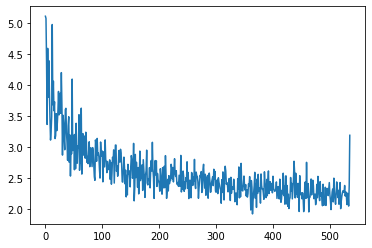

In [25]:
plt.plot(losses)

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

In [23]:
oracle.generate(vocab)

/home/rodion/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/rodion/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'There my day.<eos>'

In [24]:
oracle.generate(vocab)

/home/rodion/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/rodion/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


"I'd when and I'm vorle eve all, zepercone and are all It's of natent bazled cordmatimery in Alwife f"

## HW 1 (3 балла)
1. Обучить сеть с LSTM вместо GRU
2. Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох
3. Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

In [26]:
class LSTMOracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(LSTMOracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.LSTM(embedding_size, hidden_size, layers, batch_first=False)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(embedding, lengths)
        output, _ = self.generator(embedding)
        output = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output[0])
        return classes

    def generate(self, vocab, max_len=100):
        h = (Variable(torch.zeros(self.layers, 1, self.hidden_size)),
             Variable(torch.zeros(self.layers, 1, self.hidden_size)))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = Variable(token, volatile=True)
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [27]:
lstm_oracle = LSTMOracle(vocab.size, embedding_size=32, 
                         hidden_size=64, layers=2)


In [28]:
lstm_optimizer = torch.optim.Adam(lstm_oracle.parameters(), lr=0.001, weight_decay=1e-5)
lstm_criterion = nn.CrossEntropyLoss(reduction='none')


In [29]:
train_losses = []
test_losses = []


In [30]:
from sklearn.model_selection import train_test_split



train_size = int(len(lines) * 0.75)
test_size = len(lines) - train_size

train_dataset = Quotes(lines[:train_size], vocab)
test_dataset = Quotes(lines[train_size:], vocab)

train_dataloader = DataLoader(train_dataset, shuffle=True, 
                              batch_size=64, collate_fn=compose_batch)
test_dataloader = DataLoader(test_dataset, shuffle=True, 
                             batch_size=64, collate_fn=compose_batch)



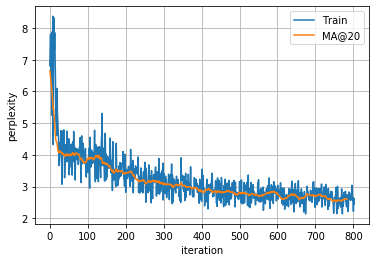

100%|██████████| 134/134 [00:13<00:00,  9.61it/s]


In [31]:
from tqdm import tqdm

for epoch in range(2):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm(train_dataloader, 
                                                          total=len(train_dataloader))):
        lstm_oracle.zero_grad()
        prediction = lstm_oracle(go, length).transpose(0, 1).transpose(1, 2)
        train_loss = (lstm_criterion(prediction, eos) * mask.float()).mean()
        train_loss.backward()
        [x.grad.clamp_(-1, 1) for x in lstm_oracle.parameters()]
        lstm_optimizer.step()
        train_losses.append(np.exp(train_loss.item()))
        
        if i % 50 == 0:
            clear_output(True)
            plt.plot(train_losses, label='Train')
            plt.plot(moving_average(train_losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()
        
    for i, (go, eos, mask, length) in enumerate(tqdm(test_dataloader, 
                                                    total=len(test_dataloader))):
        prediction = lstm_oracle(go, length).transpose(0, 1).transpose(1, 2)
        test_loss = (lstm_criterion(prediction, eos) * mask.float()).mean()
        test_losses.append(np.exp(test_loss.item()))





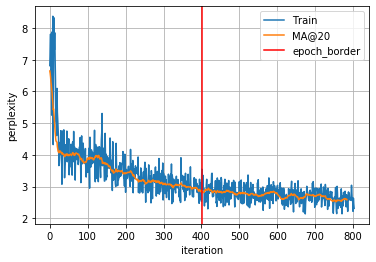

In [56]:
plt.plot(train_losses, label='Train')
plt.plot(moving_average(train_losses), label='MA@20')
plt.xlabel('iteration')
plt.ylabel('perplexity')

plt.axvline(x=len(train_dataloader), label='epoch_border', c='red')

plt.legend()
plt.grid()
plt.show()

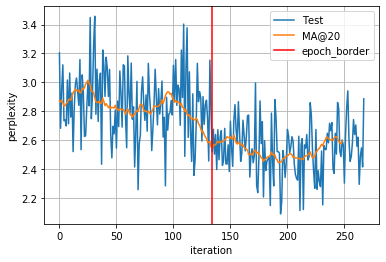

In [55]:
plt.plot(test_losses, label='Test')
plt.plot(moving_average(test_losses), label='MA@20')
plt.xlabel('iteration')
plt.ylabel('perplexity')


plt.axvline(x=len(test_dataloader), label='epoch_border', c='red')

plt.legend()
plt.grid('on')
plt.show()

In [34]:
lstm_oracle.generate(vocab)

/home/rodion/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/rodion/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


"I'es powes.<eos>"

In [40]:
np.min(test_losses), np.min(train_losses),\
np.mean(test_losses), np.mean(train_losses)

(2.093403036444304, 2.14035109196508, 2.6993437329016703, 3.1894777885637944)

 - C RMSProp как-то плохо учится, генерирует мусор.. Лосс был около 4.5 и не особо улучшался при переборе параметров. В финальной версии поставил Adam

In [41]:
from tqdm.notebook import tqdm

def my_train(model, epochs):
    train_losses = []
    test_losses = []
    
    model_optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    model_criterion = nn.CrossEntropyLoss(reduction='none')

    
    for epoch in range(epochs):
        print('epoch =', epoch)
        bar = progressbar.ProgressBar()
        for i, (go, eos, mask, length) in enumerate(tqdm(train_dataloader, 
                                                              total=len(train_dataloader))):
            model.zero_grad()
            prediction = model(go, length).transpose(0, 1).transpose(1, 2)
            train_loss = (model_criterion(prediction, eos) * mask.float()).mean()
            train_loss.backward()
            [x.grad.clamp_(-1, 1) for x in model.parameters()]
            model_optimizer.step()
            train_losses.append(np.exp(train_loss.item()))
            
        for i, (go, eos, mask, length) in enumerate(tqdm(test_dataloader, 
                                                    total=len(test_dataloader))):
            prediction = model(go, length).transpose(0, 1).transpose(1, 2)
            test_loss = (model_criterion(prediction, eos) * mask.float()).mean()
            test_losses.append(np.exp(test_loss.item()))
    return train_losses, test_losses, np.min(test_losses)

In [42]:
params = {'embedding_size': [32, 64, 32, 64],
         'hidden_size': [32, 64, 128, 256]}

In [43]:
params = [(32, 32), (64, 64), (32, 128), (64, 256)]
params

[(32, 32), (64, 64), (32, 128), (64, 256)]

In [44]:
best_loss = 1e5
for emb_size, hidd_size in params:
    model = LSTMOracle(vocab.size, embedding_size=emb_size, 
                         hidden_size=hidd_size, layers=2)
    print('embedding_size={}, hidden_size={}'.format(emb_size, hidd_size))
    
    
    
    
    tr_losses, tt_losses, min_loss = my_train(model, epochs=2)
    print('min_test_loss: ', min_loss)
    if min_loss < best_loss:
        best_loss = min_loss
        best_model = model
        best_tr_losses = tr_losses
        best_tt_losses = tt_losses
    print('##########################')

embedding_size=32, hidden_size=32
epoch = 0



epoch = 1



min_test_loss:  2.278403692404502
##########################
embedding_size=64, hidden_size=64
epoch = 0



epoch = 1



min_test_loss:  2.016607314402606
##########################
embedding_size=32, hidden_size=128
epoch = 0



epoch = 1



min_test_loss:  1.9662052963841525
##########################
embedding_size=64, hidden_size=256
epoch = 0



epoch = 1



min_test_loss:  1.8336931788356234
##########################


In [45]:
best_loss, best_model

(1.8336931788356234,
 LSTMOracle(
   (embedding): Embedding(84, 64)
   (generator): LSTM(64, 256, num_layers=2)
   (classifier): Linear(in_features=256, out_features=84, bias=True)
 ))

In [46]:
best_model.generate(vocab)

/home/rodion/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/rodion/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'Clays. with there or the stority bave whith you mave the specplessert purt-istull on afre finl is to'

In [48]:
##############
best_model.generate(vocab)

/home/rodion/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/rodion/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


"I'm wome is maghey to got surnince to me it get sporce and plose stry!<eos>"

In [101]:
##############
best_model.generate(vocab)

/home/rodion/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/rodion/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'I like at mean to go come.<eos>'

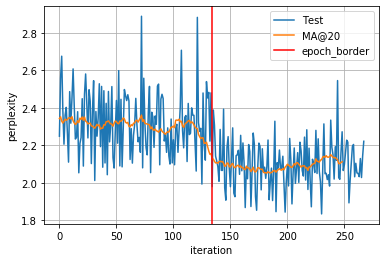

In [103]:
plt.plot(best_tt_losses, label='Test')
plt.plot(moving_average(best_tt_losses), label='MA@20')
plt.xlabel('iteration')
plt.ylabel('perplexity')


plt.axvline(x=len(test_dataloader), label='epoch_border', c='red')

plt.legend()
plt.grid('on')
plt.show()

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: